In [1]:
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [4]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
data = pd.read_csv("../NullValueHandled/NuwaraEliyaHandledNullValues.csv", index_col=0, parse_dates=True)

In [6]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000191
2019-01-02,2019-01-03,0.000191
2019-01-03,2019-01-04,0.000191
2019-01-04,2019-01-05,0.000051
2019-01-05,2019-01-06,0.000065


In [7]:
NuwaraEliya_data = data[["HCHO reading"]]
NuwaraEliya_data.head() 

,HCHO reading
Current Date,
2019-01-01,0.000191
2019-01-02,0.000191
2019-01-03,0.000191
2019-01-04,0.000051
2019-01-05,0.000065


In [14]:
NuwaraEliya_data.shape

(1826, 1)

In [15]:
X = NuwaraEliya_data.values

#### This looks like that Nuwara Eliya fomaldihyde rates have a seasonality

<Axes: xlabel='Current Date'>

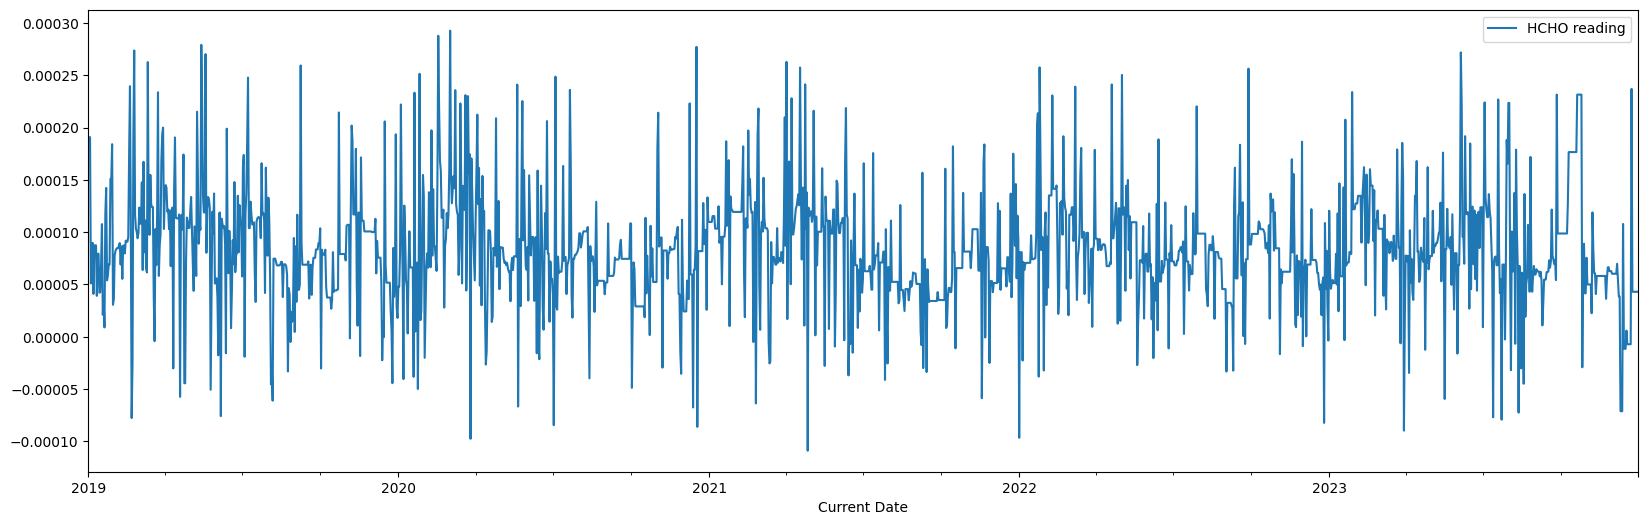

In [97]:
NuwaraEliya_data.plot(figsize=(20, 6))

In [17]:
from statsmodels.tsa.stattools import adfuller

In [19]:
test_nuwaraeliya = adfuller(NuwaraEliya_data["HCHO reading"], autolag="AIC")

In [20]:
print("ADF value : ", test_nuwaraeliya[0])
print("P value: ", test_nuwaraeliya[1])
print("Num of Lags :", test_nuwaraeliya[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_nuwaraeliya[3])
for key, val in test_nuwaraeliya[4].items():
    print("\t", key, ": ", val)

ADF value :  -7.806557397054526
P value:  7.255531724210168e-12
Num of Lags : 10
Num of Observations used for ADF Regression and Critical Calculation : 1815
	 1% :  -3.4339580289794225
	 5% :  -2.8631337437669275
	 10% :  -2.567618456010139


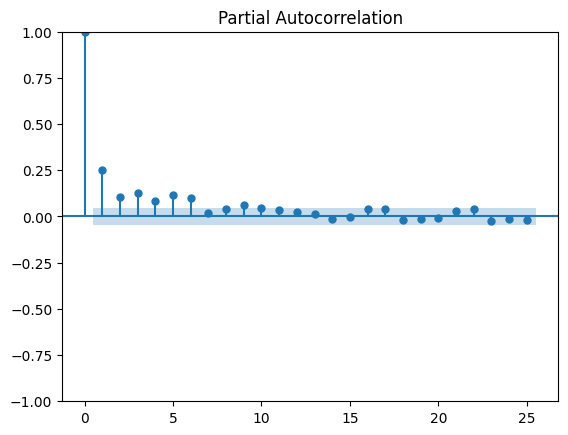

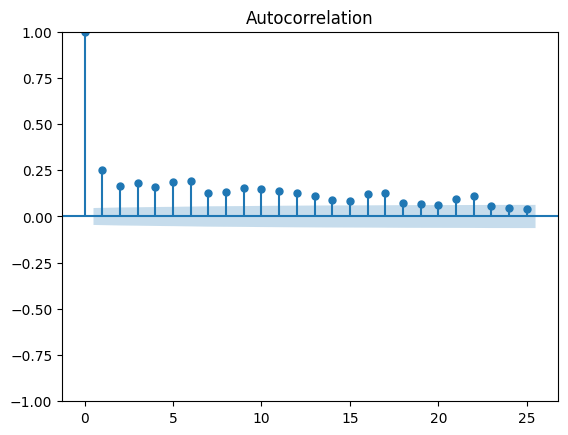

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(NuwaraEliya_data["HCHO reading"], lags=25)
acf = plot_acf(NuwaraEliya_data["HCHO reading"], lags=25) 

#### It shows there is a small seasanolity in the nuwara eliya dataset,however the partial Auto correlation plot shows there is a stationarity as well.

In [30]:
train=X[:1460]
test=X[1460:]

In [31]:
train[:5]

array([[1.90829389e-04],
       [1.90829389e-04],
       [1.90829389e-04],
       [5.09762592e-05],
       [6.45664550e-05]])

#### Check with Auto Regression Model 

In [54]:
# Import necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import AutoReg

# Assuming train is already defined as a numpy array

# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
scaler.fit(train.reshape(-1, 1))
train_normalized = scaler.transform(train.reshape(-1, 1))

# Convert the normalized data back to a numpy array
train_normalized = train_normalized.flatten()

# Train the AutoReg model
model = AutoReg(train_normalized, lags=25).fit()

In [55]:
# Make predictions using the trained model
predicted_normalized = model.predict(start=len(train_normalized), end=len(train_normalized) + len(test) - 1, dynamic=False)

# Inverse transform the predicted values to the original scale
predicted_values = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()

# Create a DataFrame for predicted values
predicted_df = pd.DataFrame(predicted_values, columns=['predicted'])

test = pd.DataFrame(test)
# Set the index of the predicted DataFrame to match the test data index
predicted_df.index = test.index

# Add the actual values from the test set to the DataFrame
predicted_df['actual'] = test

# Display the DataFrame with predicted and actual values
print(predicted_df.head())

   predicted    actual
0   0.000052 -0.000004
1   0.000054  0.000121
2   0.000072  0.000063
3   0.000057  0.000046
4   0.000057  0.000051


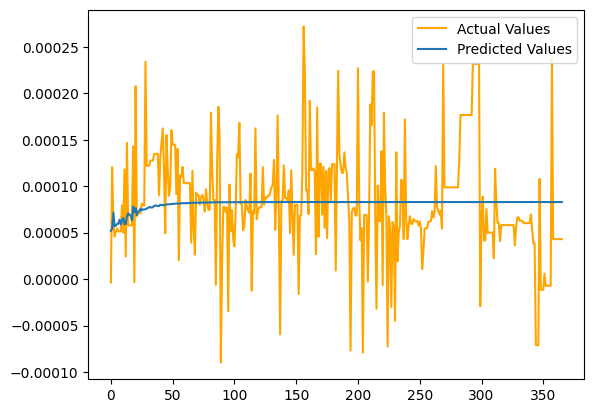

In [56]:
from matplotlib import pyplot

pyplot.plot(test, color="orange", label='Actual Values')
pyplot.plot(predicted_values, label='Predicted Values')
pyplot.legend()

#### There is a fluctuation of the values, but it cannot findout the pattern properly

In [57]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

# Assuming you have your test and predicted values stored in 'test' and 'predicted_values' variables

# Calculate the metrics
r_squared = r2_score(test, predicted_values)
mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = mean_squared_error(test, predicted_values, squared=False)
median_absolute = median_absolute_error(test, predicted_values)
explained_variance = explained_variance_score(test, predicted_values)

table_headers = ["Metric", "Value"]
table_data = {
    "R-squared (Coefficient of Determination)": "{:.12f}".format(r_squared),
    "Mean Absolute Error (MAE)": "{:.12f}".format(mae),
    "Mean Squared Error (MSE)": "{:.12f}".format(mse),
    "Root Mean Squared Error (RMSE)": "{:.12f}".format(rmse),
    "Median Absolute Error": "{:.12f}".format(median_absolute),
    "Explained Variance Score": "{:.12f}".format(explained_variance)
}

# Create DataFrame
df = pd.DataFrame(table_data.items(), columns=table_headers)

df

,Metric,Value
0,R-squared (Coefficient of Determination),-0.002890420843
1,Mean Absolute Error (MAE),0.000041806513
2,Mean Squared Error (MSE),0.000000003358
3,Root Mean Squared Error (RMSE),0.000057947750
4,Median Absolute Error,0.000028070465
5,Explained Variance Score,-0.000492248450


#### Nuwara Eliya with LSTM

In [53]:
data = pd.read_csv("../NullValueHandled/NuwaraEliyaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [54]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000191
1   2019-01-02      0.000191
2   2019-01-03      0.000191
3   2019-01-04      0.000051
4   2019-01-05      0.000065


In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=130, batch_size=32, validation_split=0.2)

Epoch 1/130
37/37 [==============================] - 116s 703ms/step - loss: 1.1291 - mean_squared_error: 1.1291 - val_loss: 0.6458 - val_mean_squared_error: 0.6458
Epoch 2/130
37/37 [==============================] - 14s 375ms/step - loss: 1.0729 - mean_squared_error: 1.0729 - val_loss: 0.6482 - val_mean_squared_error: 0.6482
Epoch 3/130
37/37 [==============================] - 14s 383ms/step - loss: 1.0558 - mean_squared_error: 1.0558 - val_loss: 0.8067 - val_mean_squared_error: 0.8067
Epoch 4/130
37/37 [==============================] - 12s 318ms/step - loss: 1.0386 - mean_squared_error: 1.0386 - val_loss: 0.6398 - val_mean_squared_error: 0.6398
Epoch 5/130
37/37 [==============================] - 12s 324ms/step - loss: 1.0303 - mean_squared_error: 1.0303 - val_loss: 0.5760 - val_mean_squared_error: 0.5760
Epoch 6/130
37/37 [==============================] - 14s 366ms/step - loss: 1.0190 - mean_squared_error: 1.0190 - val_loss: 0.6171 - val_mean_squared_error: 0.6171
Epoch 7/130
37/

Epoch 51/130
37/37 [==============================] - 15s 404ms/step - loss: 0.9110 - mean_squared_error: 0.9110 - val_loss: 0.5877 - val_mean_squared_error: 0.5877
Epoch 52/130
37/37 [==============================] - 15s 397ms/step - loss: 0.9196 - mean_squared_error: 0.9196 - val_loss: 0.5692 - val_mean_squared_error: 0.5692
Epoch 53/130
37/37 [==============================] - 15s 404ms/step - loss: 0.9028 - mean_squared_error: 0.9028 - val_loss: 0.5522 - val_mean_squared_error: 0.5522
Epoch 54/130
37/37 [==============================] - 16s 450ms/step - loss: 0.8733 - mean_squared_error: 0.8733 - val_loss: 0.6433 - val_mean_squared_error: 0.6433
Epoch 55/130
37/37 [==============================] - 16s 423ms/step - loss: 0.8786 - mean_squared_error: 0.8786 - val_loss: 0.5960 - val_mean_squared_error: 0.5960
Epoch 56/130
37/37 [==============================] - 18s 496ms/step - loss: 0.9054 - mean_squared_error: 0.9054 - val_loss: 0.5802 - val_mean_squared_error: 0.5802
Epoch 57/1

Epoch 101/130
37/37 [==============================] - 4s 118ms/step - loss: 0.4996 - mean_squared_error: 0.4996 - val_loss: 0.9404 - val_mean_squared_error: 0.9404
Epoch 102/130
37/37 [==============================] - 4s 118ms/step - loss: 0.5150 - mean_squared_error: 0.5150 - val_loss: 0.7435 - val_mean_squared_error: 0.7435
Epoch 103/130
37/37 [==============================] - 4s 118ms/step - loss: 0.4978 - mean_squared_error: 0.4978 - val_loss: 0.7961 - val_mean_squared_error: 0.7961
Epoch 104/130
37/37 [==============================] - 5s 143ms/step - loss: 0.4634 - mean_squared_error: 0.4634 - val_loss: 0.8206 - val_mean_squared_error: 0.8206
Epoch 105/130
37/37 [==============================] - 5s 134ms/step - loss: 0.5109 - mean_squared_error: 0.5109 - val_loss: 1.0707 - val_mean_squared_error: 1.0707
Epoch 106/130
37/37 [==============================] - 5s 131ms/step - loss: 0.4801 - mean_squared_error: 0.4801 - val_loss: 1.0250 - val_mean_squared_error: 1.0250
Epoch 107/

12/12 [==============================] - 6s 29ms/step


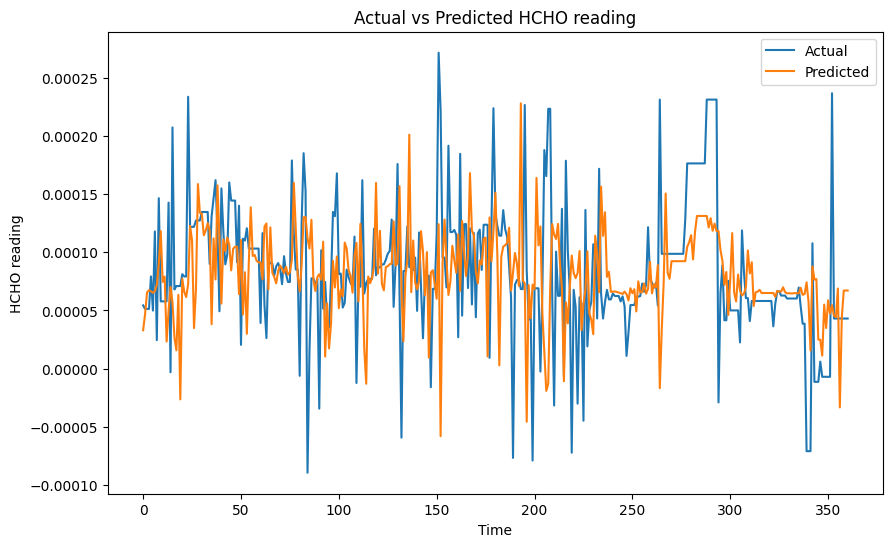

In [56]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [57]:
predictions.shape 

(361, 1)

46/46 [==============================] - 1s 29ms/step


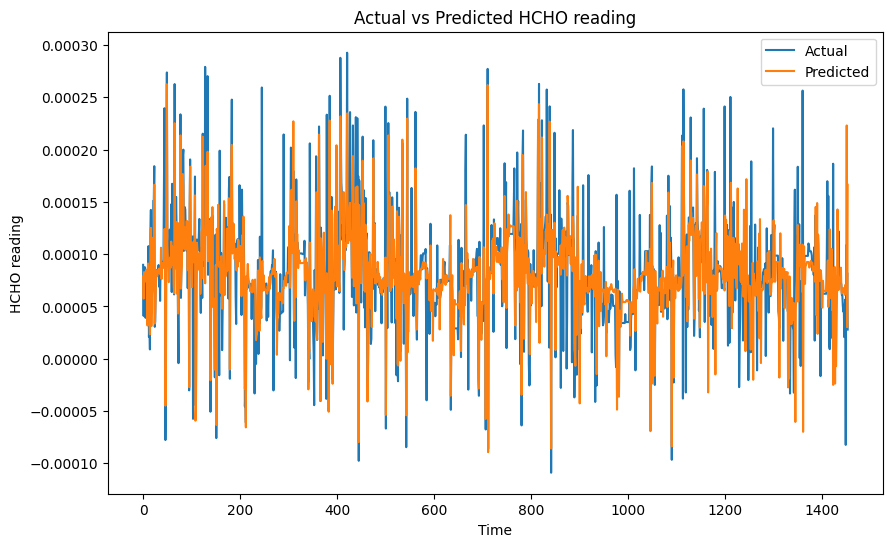

In [58]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 2s 34ms/step


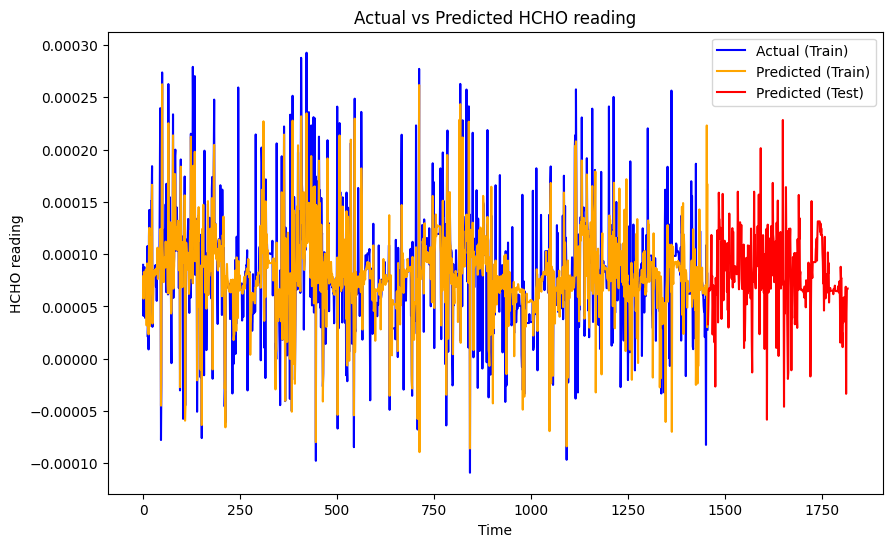

In [59]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [60]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.576246358035948
Mean Absolute Error (MAE): 2.11378138191922e-05
Mean Squared Error (MSE): 1.2030519250184274e-09
Root Mean Squared Error (RMSE): 3.468503892196789e-05
Median Absolute Error: 1.218133541423691e-05
Explained Variance Score: 0.577513811343885


19:15:26 - cmdstanpy - INFO - Chain [1] start processing
19:15:26 - cmdstanpy - INFO - Chain [1] done processing


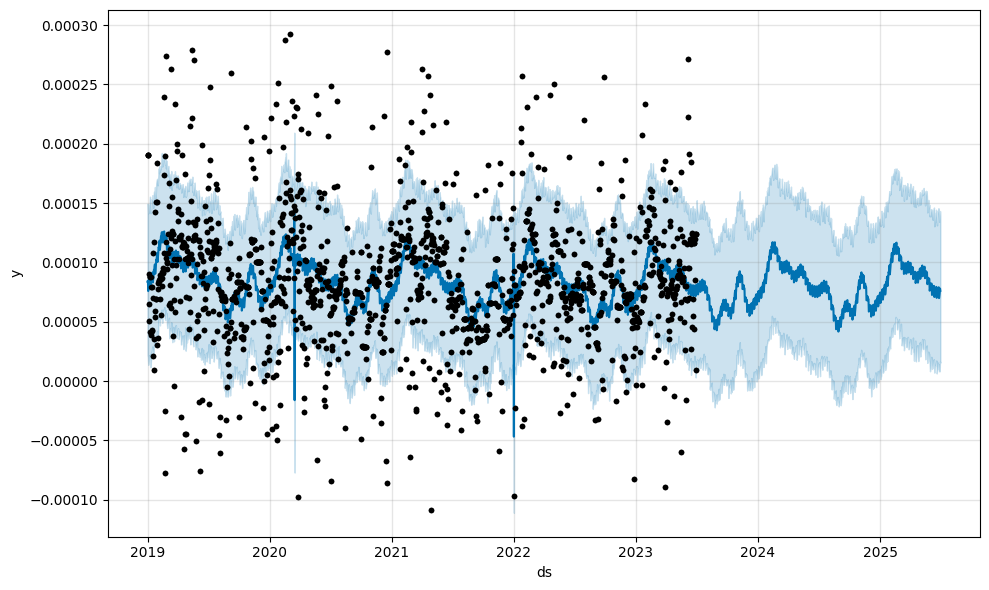

In [302]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/NuwaraEliyaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.9 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=730)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

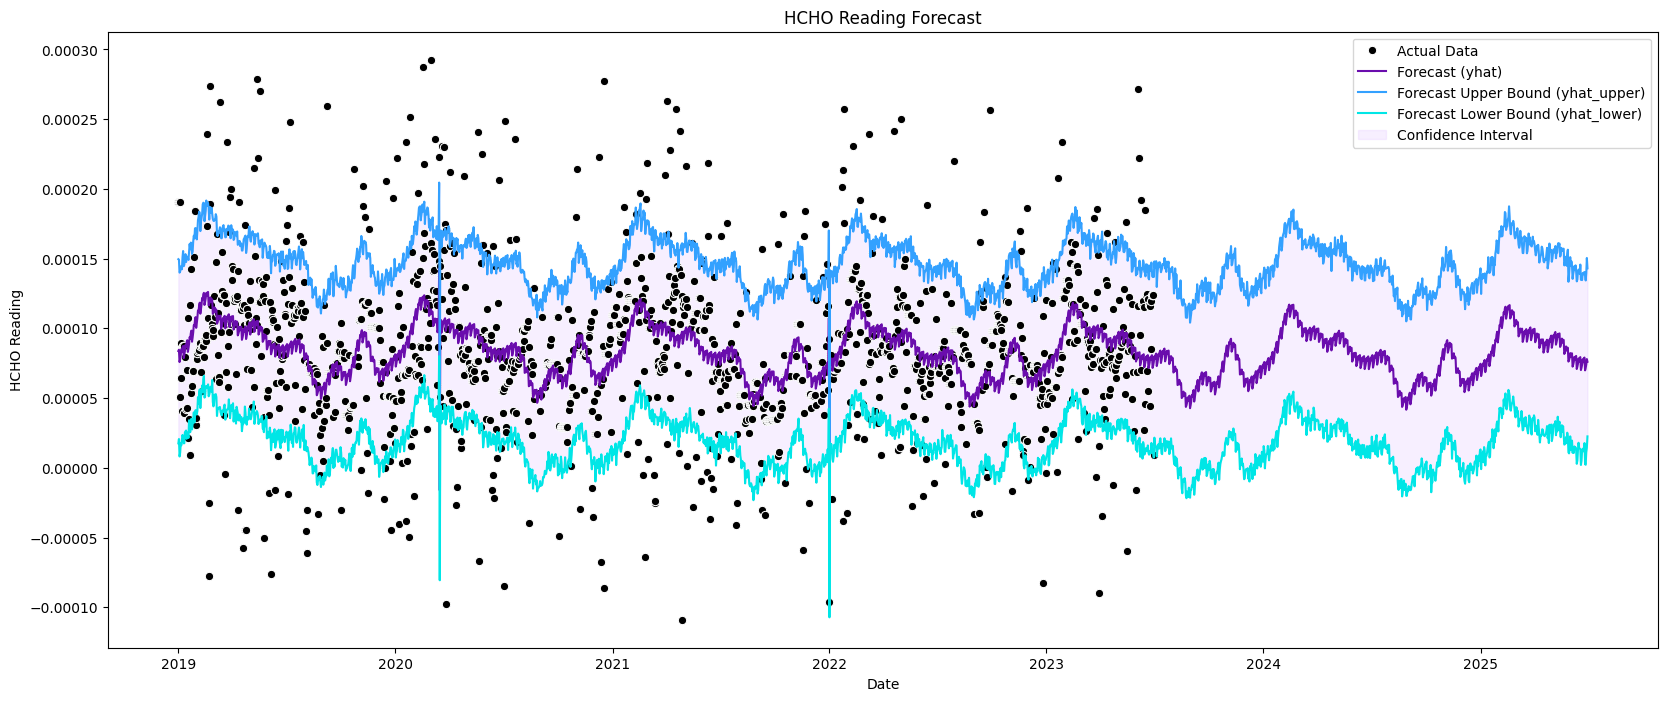

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

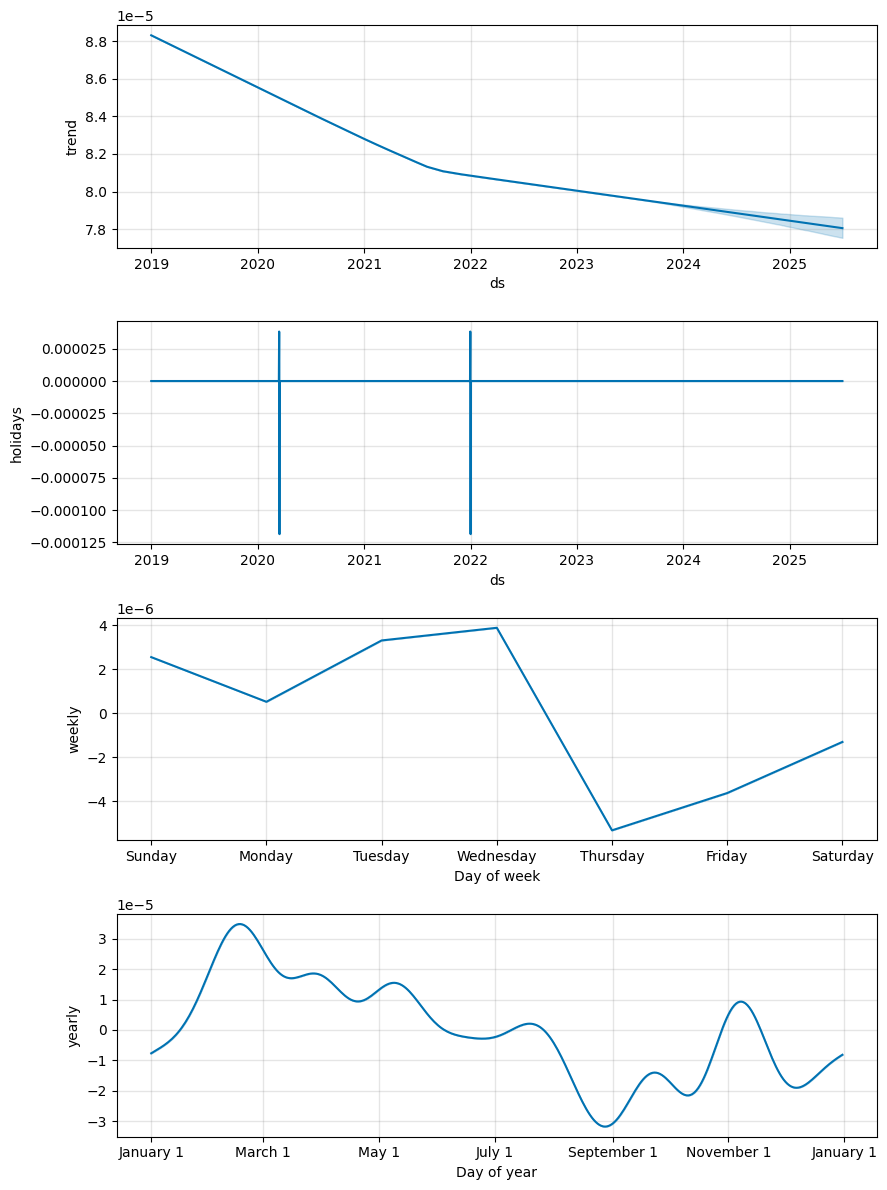

In [285]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [286]:
from tabulate import tabulate

y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -0.03332473696988747
Mean Absolute Error (MAE): 4.640746178003005e-05
Mean Squared Error (MSE): 4.394006741650661e-09
Root Mean Squared Error (RMSE): 6.628730452847408e-05
Median Absolute Error: 2.999635321502574e-05
Explained Variance Score: -0.013782492770155974


In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/BibileMonaragalaHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

#### Nuwara Eliya Multi Variate Model

In [115]:
data = pd.read_csv("../AnalysedFinalData/nuwaraEliyaData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   float64
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   int64  
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [117]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000191,Nuwara Eliya Proper,6.967,80.767,1880.0,0.0,61.0,71.0,49.0,768000,1741,441.13,101,0.031612,0.000012,0.115633,0,0,Before,Before
1,2019-01-02,0.000191,Nuwara Eliya Proper,6.967,80.767,1880.0,0.0,59.0,71.0,49.0,768000,1741,441.13,101,0.031380,0.000015,0.115633,0,0,Before,Before
2,2019-01-03,0.000191,Nuwara Eliya Proper,6.967,80.767,1880.0,0.0,59.0,71.0,49.0,768000,1741,441.13,101,0.030029,0.000017,0.115633,0,0,Before,Before
3,2019-01-04,0.000051,Nuwara Eliya Proper,6.967,80.767,1880.0,0.0,59.0,72.0,47.0,768000,1741,441.13,101,0.032376,0.000015,0.115633,0,0,Before,Before
4,2019-01-05,0.000065,Nuwara Eliya Proper,6.967,80.767,1880.0,0.0,55.0,68.0,48.0,768000,1741,441.13,101,0.031173,0.000016,0.115633,0,0,Before,Before


#### remove constant data

In [118]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [119]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)'], inplace=True)

In [120]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000191,0.0,61.0,71.0,49.0,768000,441.13,0.031612,0.000012,0.115633,0,0,Before,Before
1,2019-01-02,0.000191,0.0,59.0,71.0,49.0,768000,441.13,0.031380,0.000015,0.115633,0,0,Before,Before
2,2019-01-03,0.000191,0.0,59.0,71.0,49.0,768000,441.13,0.030029,0.000017,0.115633,0,0,Before,Before
3,2019-01-04,0.000051,0.0,59.0,72.0,47.0,768000,441.13,0.032376,0.000015,0.115633,0,0,Before,Before
4,2019-01-05,0.000065,0.0,55.0,68.0,48.0,768000,441.13,0.031173,0.000016,0.115633,0,0,Before,Before


#### Encode Categorical data

In [121]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [122]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000191,0.0,61.0,71.0,49.0,768000,441.13,0.031612,0.000012,0.115633,0,0,1,1
1,2019-01-02,0.000191,0.0,59.0,71.0,49.0,768000,441.13,0.031380,0.000015,0.115633,0,0,1,1
2,2019-01-03,0.000191,0.0,59.0,71.0,49.0,768000,441.13,0.030029,0.000017,0.115633,0,0,1,1
3,2019-01-04,0.000051,0.0,59.0,72.0,47.0,768000,441.13,0.032376,0.000015,0.115633,0,0,1,1
4,2019-01-05,0.000065,0.0,55.0,68.0,48.0,768000,441.13,0.031173,0.000016,0.115633,0,0,1,1


#### Check correlations

In [123]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr = corr.T
corr

,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
HCHO reading,1.0,-0.025234,0.029537,0.153014,-0.139301,-0.033461,-0.03347,0.142956,0.099964,-0.030131,-0.069096,-0.055533,-0.034339,-0.019078


In [124]:
corr.to_csv("../OtherData/NuwaraEliyaCorrelationData.csv")

In [125]:
data.shape

(1826, 15)

#### remove covid range status

In [126]:
data.drop(columns=["covid_range_status"], inplace=True)

#### Devide X and Y

In [127]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [128]:
X.head()

,Current Date,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status
0,2019-01-01,0.0,61.0,71.0,49.0,768000,441.13,0.031612,0.000012,0.115633,0,0,1
1,2019-01-02,0.0,59.0,71.0,49.0,768000,441.13,0.031380,0.000015,0.115633,0,0,1
2,2019-01-03,0.0,59.0,71.0,49.0,768000,441.13,0.030029,0.000017,0.115633,0,0,1
3,2019-01-04,0.0,59.0,72.0,47.0,768000,441.13,0.032376,0.000015,0.115633,0,0,1
4,2019-01-05,0.0,55.0,68.0,48.0,768000,441.13,0.031173,0.000016,0.115633,0,0,1


#### Select features based on Correlations

In [129]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.025234
TAVG                    0.029537
TMAX                    0.153014
TMIN                   -0.139301
Population             -0.033461
population_density     -0.033470
carbon_monoxide         0.142956
nitogen_dioxide         0.099964
ozone                  -0.030131
new_covid_patients     -0.069096
total_covid_patients   -0.055533
lockdown_status        -0.034339
Name: HCHO reading, dtype: float64

In [130]:
X = X[["Current Date", "carbon_monoxide", "TMAX"]]
X.head() 

,Current Date,carbon_monoxide,TMAX
0,2019-01-01,0.031612,71.0
1,2019-01-02,0.031380,71.0
2,2019-01-03,0.030029,71.0
3,2019-01-04,0.032376,72.0
4,2019-01-05,0.031173,68.0


In [131]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Current Date     1826 non-null   object 
 1   carbon_monoxide  1826 non-null   float64
 2   TMAX             1826 non-null   float64
dtypes: float64(2), object(1)
memory usage: 42.9+ KB


#### Standardize, variable data

In [132]:
from sklearn.preprocessing import StandardScaler
# Select columns of interest
selected_columns = ["carbon_monoxide", "TMAX"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X.set_index("Current Date", inplace=True)

In [133]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carbon_monoxide  1826 non-null   float64
 1   TMAX             1826 non-null   float64
dtypes: float64(2)
memory usage: 42.8 KB


##### Standardize target variable

In [134]:
y = data['HCHO reading']

y.head()

0    0.000191
1    0.000191
2    0.000191
3    0.000051
4    0.000065
Name: HCHO reading, dtype: float64

In [135]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [136]:
X_scaled = X  

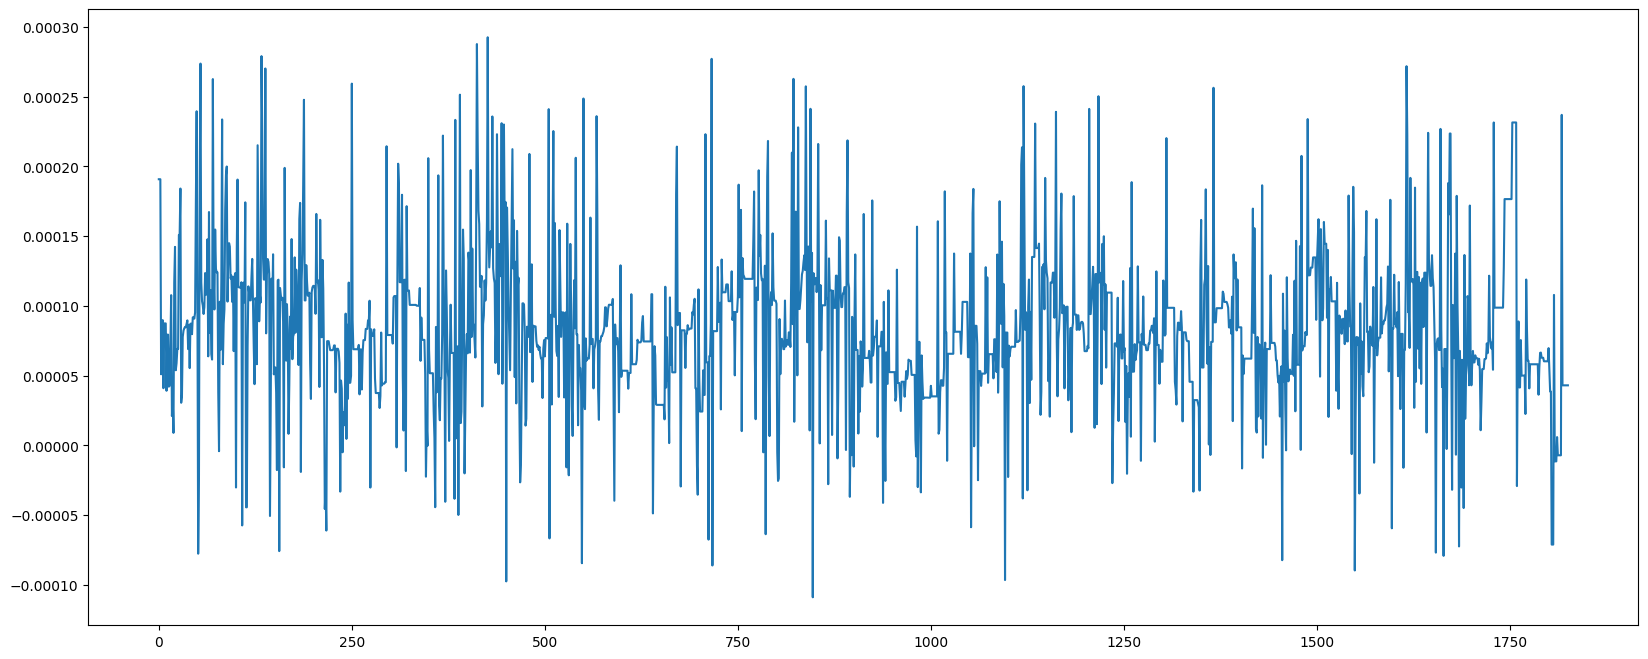

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

In [ ]:
print(X_scaled.head())

#### Apply multivariate time series model

In [141]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError

# Assuming X_scaled and y_scaled are already defined

# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential([
    Bidirectional(LSTM(units=400, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=200, return_sequences=True, activation="tanh")),  # New Bidirectional LSTM layer with tanh activation
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=100, activation="relu")),  # New Bidirectional LSTM layer with relu activation
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=50, activation='relu'),  # Adding a Dense layer with relu activation
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1, activation='linear')  # Adding the output layer with linear activation
])

# Compilation of the model
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/150
46/46 [==============================] - 21s 94ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 2/150
46/46 [==============================] - 1s 30ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 3/150
46/46 [==============================] - 1s 27ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 4/150
46/46 [==============================] - 1s 27ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 5/150
46/46 [==============================] - 1s 28ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 6/150
46/46 [==============================] - 1s 26ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 7/150
46/46 [========

46/46 [==============================] - 1s 25ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 52/150
46/46 [==============================] - 1s 25ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 53/150
46/46 [==============================] - 1s 25ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 54/150
46/46 [==============================] - 1s 26ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 55/150
46/46 [==============================] - 1s 26ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 56/150
46/46 [==============================] - 1s 25ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 57/150
46/46 [===============

46/46 [==============================] - 1s 26ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0225 - val_mean_squared_error: 0.0225
Epoch 102/150
46/46 [==============================] - 1s 26ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 103/150
46/46 [==============================] - 1s 26ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 104/150
46/46 [==============================] - 1s 26ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 105/150
46/46 [==============================] - 1s 26ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0227 - val_mean_squared_error: 0.0227
Epoch 106/150
46/46 [==============================] - 1s 25ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 107/150
46/46 [=========

12/12 [==============================] - 0s 6ms/step - loss: 0.0232 - mean_squared_error: 0.0232
Test Loss: [0.02315489761531353, 0.02315489761531353]
12/12 [==============================] - 3s 8ms/step


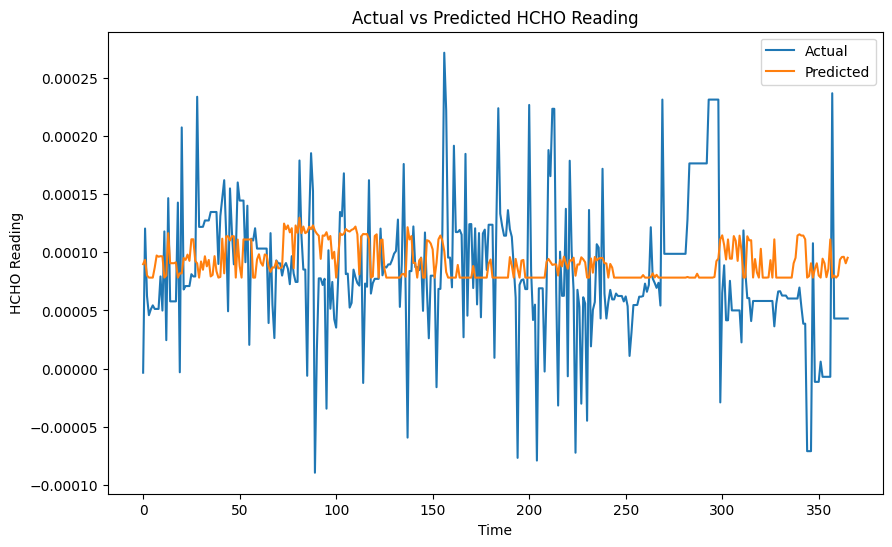

In [142]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

46/46 [==============================] - 0s 6ms/step


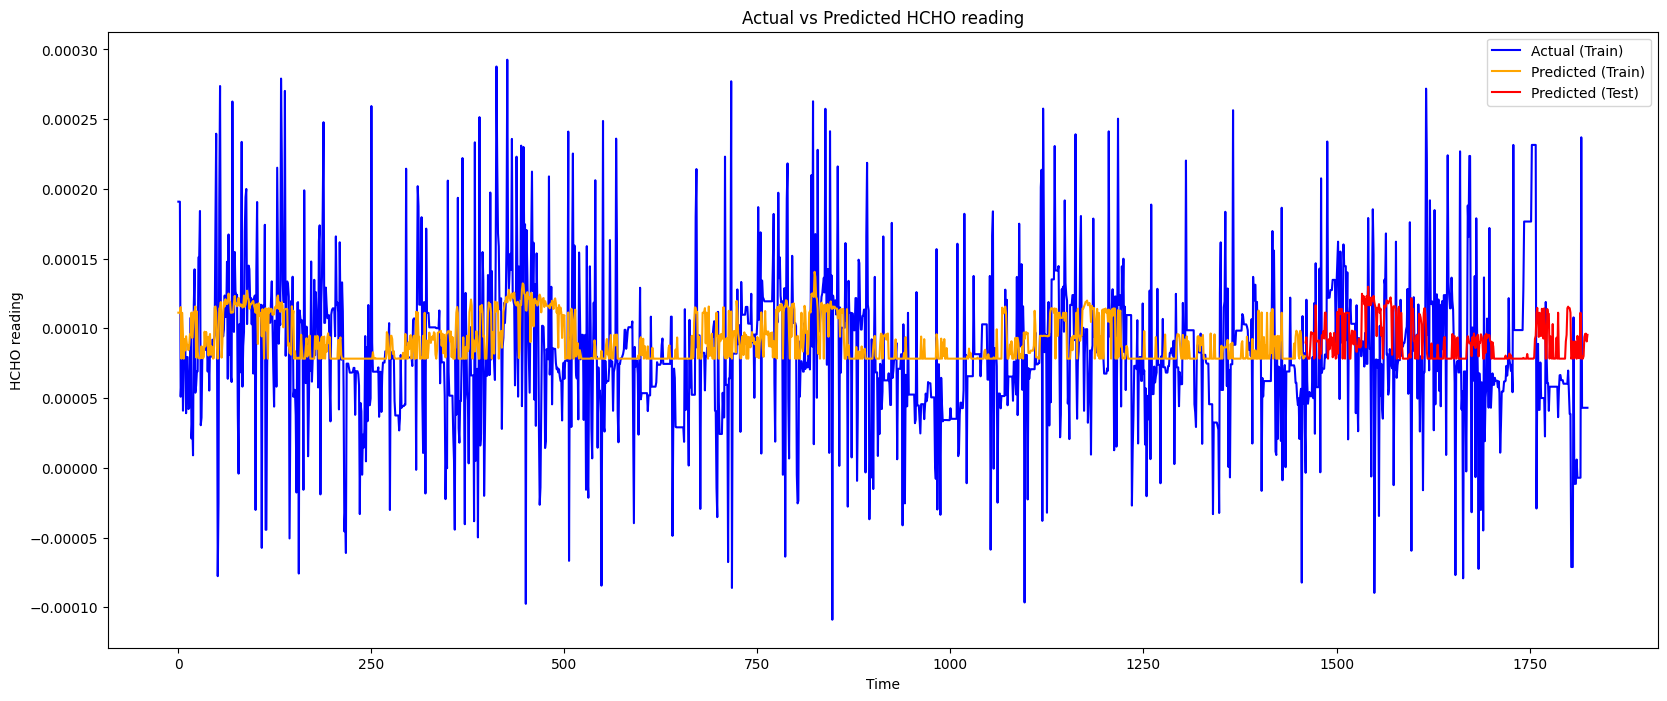

In [143]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(20, 8))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [144]:
r2 = (r2_score(predictions_train, actual_train))
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test) 
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): -10.381625738770074
Mean Absolute Error (MAE): 4.619589278323558e-05
Mean Squared Error (MSE): 3.733570254211873e-09
Root Mean Squared Error (RMSE): 6.110294799935493e-05
Median Absolute Error: 3.50089173264692e-05
Explained Variance Score: -0.10050128803670422
